<a href="https://colab.research.google.com/github/paotabetai/NLP100/blob/master/C9_RNN_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
## 同一ディレクトリ内にhttps://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g からダウンロードした学習済み単語ベクトルを配置しているものとする

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip


--2023-04-02 13:31:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  10.2MB/s    in 2.7s    

2023-04-02 13:31:41 (10.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [3]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

CATEGORIES = [
    'b',
    't',
    'e',
    'm'
]

with open('./newsCorpora.csv') as f:
   _all_news = [news.split('\t')[1] + '\t' + news.split('\t')[4] for news in f.readlines() if news.split('\t')[3] in TARGET_PUBLISHERS]

max_length = 0

for news in _all_news:
  if len(news.split('\t')[0].split(' ')) > max_length:
    max_length = len(news.split('\t')[0].split(' '))

all_news = []

for news in _all_news:
  diff = max_length - len(news.split('\t')[0].split(' ')) 
  news = 'BOS ' * (diff + 1) + news.split('\t')[0] + ' EOS' + '\t' + news.split('\t')[1] + '\n'
  all_news.append(news)

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

with open('./train.txt', mode='w') as f:
  f.writelines(train_data)

with open('./valid.txt', mode='w') as f:
  f.writelines(valid_data)

with open('./test.txt', mode='w') as f:
  f.writelines(test_data)

print(f'学習データ事例数: {len(train_data)}')
print(f'評価データ事例数: {len(test_data)}')

学習データ事例数: 10684
評価データ事例数: 1336


In [ ]:
# 80

def calculate_id(filepath):
  word_dic = {}
  result = {}
  with open(filepath, mode='r') as f:
    data = f.readlines()
    for row in data:
      for word in row.split('\t')[0].strip("'").split(' '):
        if not word in word_dic:
          word_dic[word] = 0
        if word not in ['BOS', 'EOS', '...', '', '-']:
          word_dic[word] += 1
  sorted_words = sorted([(key, value) for key, value in word_dic.items()], key=lambda x: x[1], reverse=True)
  i = 0
  for word in sorted_words:
    if word[1] > 1:
      i += 1
      result[word[0]] = i
    else:
      result[word[0]] = 0
  return result, i

words, T = calculate_id('./train.txt')


In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


if torch.cuda.is_available():
    d_type = "cuda:0"
else:
    d_type = "cpu"

device = torch.device(d_type)

class RNN(nn.Module):

  def __init__(self,
               input_size,
               hidden_size,
               output_size,
               n_layers):
    super(RNN, self).__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    batch_size = x.size()[0]
    x_rnn, hidden = self.rnn(x, None)
    x = torch.nn.functional.softmax(self.fc(x_rnn[:, -1, :]), dim=1)
    return x



EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9


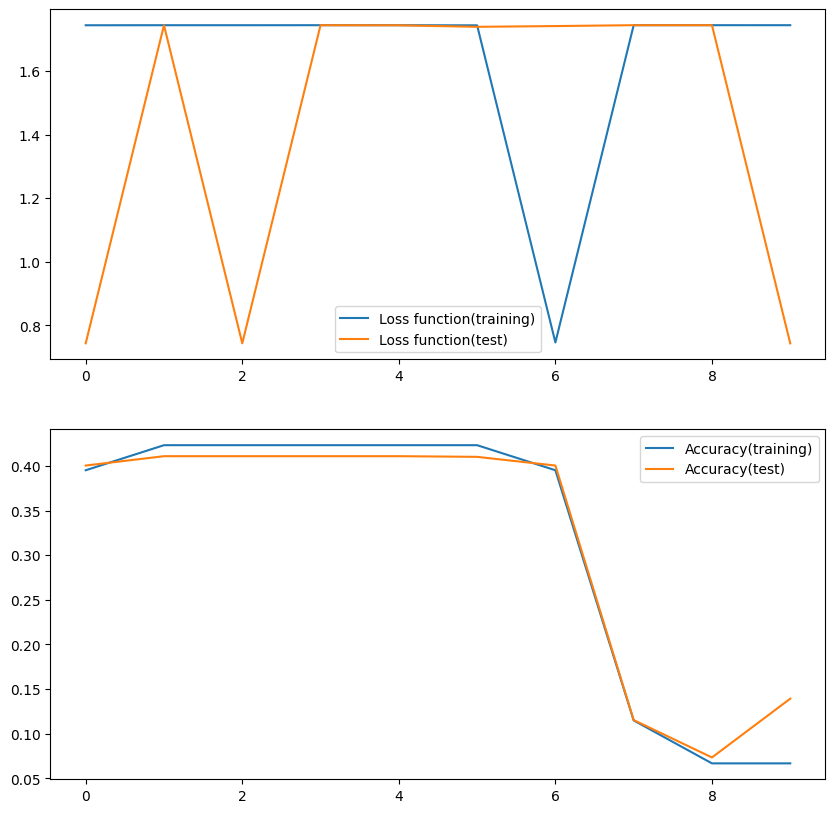

In [ ]:
# 81, 82, 83
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


dw = 300
dh = 50
BATCHSIZE = 1
EPOCH = 10

with open('./train.txt') as f:
  news = f.readlines()
  _X = [n.split('\t')[0] for n in news]
  _Y = [n.split('\t')[1] for n in news]
  X = []
  Y = []
  for x in _X:
    w_list = x.split(' ')
    wvs = []
    for w in w_list:
      if words[w] <= dw - 1:
        wv = np.zeros(dw)
        wv[words[w]] = 1
      else:
        wv = np.zeros(dw)
        wv[0] = 1
      wvs.append(wv)
    X.append(wvs)
  
  for y in _Y:
    yv = np.zeros(len(CATEGORIES))
    yv[CATEGORIES.index(y.strip())] = 1
    Y.append(yv)

dtype = torch.float
X = torch.from_numpy(np.array(X)).type(dtype).to(device)
Y = torch.from_numpy(np.array(Y)).type(dtype).to(device)
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)


with open('./test.txt') as f:
  news = f.readlines()
  _X = [n.split('\t')[0] for n in news]
  _Y = [n.split('\t')[1] for n in news]
  test_X = []
  test_Y = []
  for x in _X:
    w_list = x.split(' ')
    wvs = []
    for w in w_list:
      if w in words and words[w] <= dw - 1:
        wv = np.zeros(dw)
        wv[words[w]] = 1
      else:
        wv = np.zeros(dw)
        wv[0] = 1
      wvs.append(wv)
    test_X.append(wvs)
  
  for y in _Y:
    yv = np.zeros(len(CATEGORIES))
    yv[CATEGORIES.index(y.strip())] = 1
    test_Y.append(yv)

dtype = torch.float
test_X = torch.from_numpy(np.array(test_X)).type(dtype).to(device)
test_Y = torch.from_numpy(np.array(test_Y)).type(dtype).to(device)
testdataset = TensorDataset(test_X, test_Y)
testloader = DataLoader(testdataset, batch_size=BATCHSIZE, shuffle=True)


model = RNN(dw, dh, len(CATEGORIES), 1).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
for i in range(EPOCH):
  for x,y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  correct = 0
  num_train = 0

  for x, y in loader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_train += 1
  train_losses.append(float(loss))
  train_accuracy.append(correct/num_train)
  optimizer.zero_grad()

  correct = 0
  num_test = 0

  for x, y in testloader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_test += 1
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  test_losses.append(float(loss))
  test_accuracy.append(correct/num_test)
  optimizer.zero_grad()

  print(f"EPOCH {i}")

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_accuracy))], train_accuracy, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_accuracy))], test_accuracy, label="Accuracy(test)")
ax1.legend()
ax2.legend() # Google Colaboratoryでは動的なグラフ生成が手間なため割愛

In [6]:
# 84
from gensim.models import KeyedVectors

DATASETPATH = '/content/drive/MyDrive/Colab Notebooks/NLP100/GoogleNews-vectors-negative300.bin' 

wv = KeyedVectors.load_word2vec_format(DATASETPATH, binary=True)

In [53]:
import csv
import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

CATEGORIES = [
    'b',
    't',
    'e',
    'm'
]


NEWS_CATEGORIES = {
    'b' : 0,
    't' : 1,
    'e' : 2,
    'm' : 3
}

SENTENCE_LEN = 30
dw = 300
dh = 50
BATCHSIZE = 1

with open('./newsCorpora.csv') as f:
  reader = csv.reader(f, delimiter='\t')
  all_news = [[news[4], news[1]] for news in reader if news[3] in TARGET_PUBLISHERS]

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

def vector_create(data, filepath, num):
  X = []
  Y = []
  for news in data:
    title, category = news[1], news[0]
    words = []
    for word in title.split(' '):
      if len(words) >= num:
        break
      if word:
        try:
          words.append(wv[word]) #. most_similarで抽出しようとするとメモリが死ぬため、データセットに存在する場合のみ扱う
        except:
          continue
    if len(words) < num:
      words += [wv['EOS']] * (num - len(words))
    if words:
      X.append(words)
      y = int(NEWS_CATEGORIES[news[0]])
      _Y = np.zeros(4)
      _Y[y] = 1
      Y.append(_Y)
  return X, Y
      
train_X, train_Y = vector_create(train_data, 'train', SENTENCE_LEN)
valid_X, valid_Y = vector_create(valid_data, 'valid', SENTENCE_LEN)
test_X, test_Y = vector_create(test_data, 'test', SENTENCE_LEN)

train_X = np.array(train_X)
train_Y = np.array(train_Y)
dtype = torch.float
X = torch.from_numpy(train_X).type(dtype)
Y = torch.from_numpy(train_Y).type(dtype)
X_GPU = X.to('cuda')
Y_GPU = Y.to('cuda')
dataset = TensorDataset(X_GPU, Y_GPU)
loader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)

test_X = np.array(test_X)
test_Y = np.array(test_Y)
dtype = torch.float
test_X = torch.from_numpy(test_X).type(dtype)
test_Y = torch.from_numpy(test_Y).type(dtype)
test_X_GPU = test_X.to('cuda')
test_Y_GPU = test_Y.to('cuda')
test_dataset = TensorDataset(test_X_GPU, test_Y_GPU)
testloader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=True)


model = RNN(dw, dh, len(CATEGORIES), 1).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)


EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9


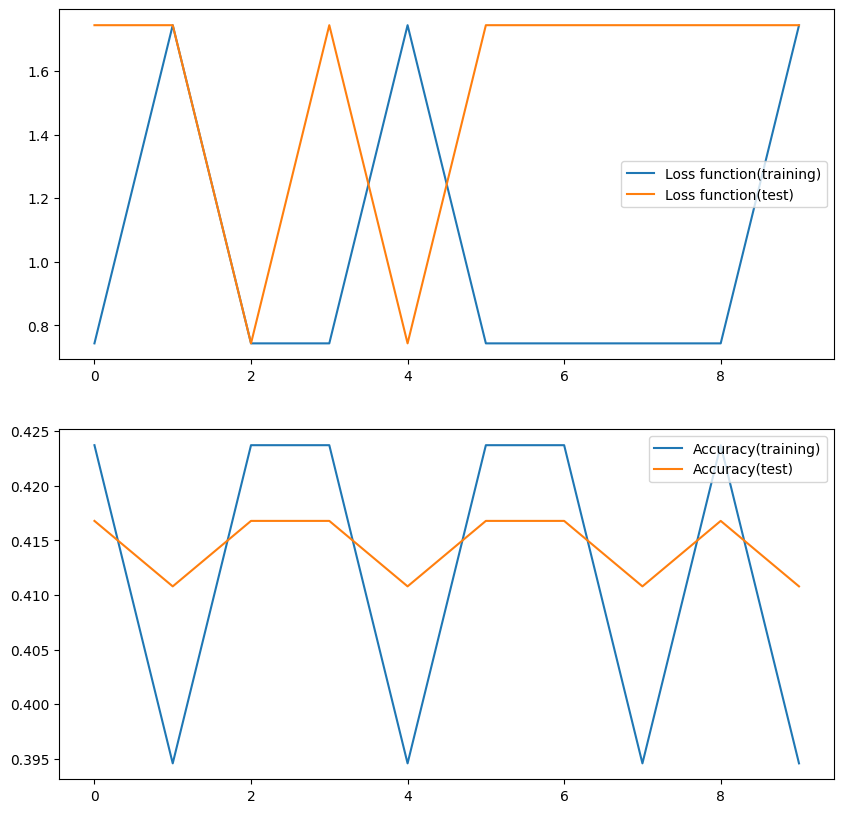

In [56]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

EPOCH = 10

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
for i in range(EPOCH):
  for x,y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  correct = 0
  num_train = 0

  for x, y in loader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_train += 1
  train_losses.append(float(loss))
  train_accuracy.append(correct/num_train)
  optimizer.zero_grad()

  correct = 0
  num_test = 0

  for x, y in testloader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_test += 1
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  test_losses.append(float(loss))
  test_accuracy.append(correct/num_test)
  optimizer.zero_grad()

  print(f"EPOCH {i}")

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_accuracy))], train_accuracy, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_accuracy))], test_accuracy, label="Accuracy(test)")
ax1.legend()
ax2.legend() # Google Colaboratoryでは動的なグラフ生成が手間なため割愛

In [64]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


if torch.cuda.is_available():
    d_type = "cuda:0"
else:
    d_type = "cpu"

device = torch.device(d_type)

class Bi_RNN(nn.Module):

  def __init__(self,
               input_size,
               hidden_size,
               output_size,
               n_layers):
    super(Bi_RNN, self).__init__()
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers=n_layers, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(hidden_size * 2, output_size)

  def forward(self, x):
    batch_size = x.size()[0]
    x_rnn, hidden = self.rnn(x, None)
    x = torch.nn.functional.softmax(self.fc(x_rnn[:, -1, :]), dim=1)
    return x



EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9


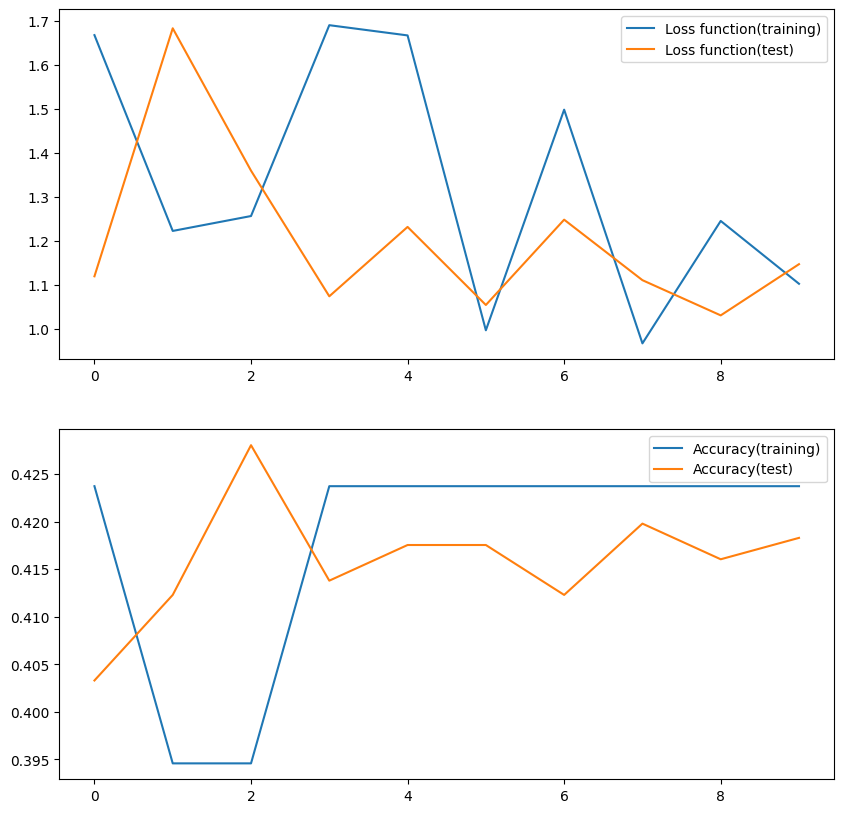

In [65]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

dw = 300
dh = 50
EPOCH = 10

model = Bi_RNN(dw, dh, len(CATEGORIES), 1).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
for i in range(EPOCH):
  for x,y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  correct = 0
  num_train = 0

  for x, y in loader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_train += 1
  train_losses.append(float(loss))
  train_accuracy.append(correct/num_train)
  optimizer.zero_grad()

  correct = 0
  num_test = 0

  for x, y in testloader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_test += 1
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  test_losses.append(float(loss))
  test_accuracy.append(correct/num_test)
  optimizer.zero_grad()

  print(f"EPOCH {i}")

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_accuracy))], train_accuracy, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_accuracy))], test_accuracy, label="Accuracy(test)")
ax1.legend()
ax2.legend() # Google Colaboratoryでは動的なグラフ生成が手間なため割愛